In [39]:
import torch
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
import pandas as pd
import json

In [3]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Get Data and Model

In [17]:
class SmokingDataset(Dataset):
    def __init__(self, dir):
        self.dir = dir
    
    def __len__(self):
        return len(os.listdir(self.dir))
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            stop, start, step = key.indices(len(self))

            length = len(range(stop, start, step))
            X = torch.zeros([length, 300])
            y = torch.zeros([length, 1])

            for j,i in enumerate(range(stop, start, step)):
                xi, yi = self[i]
                X[j] = xi
                y[j] = yi

            return (X, y)

        elif isinstance(key, int):
            X, y = torch.load(os.path.join(self.dir, f'{key}.pt'))
            return (X.flatten(), y)

In [18]:
test_dataset = SmokingDataset('pipeline/4_all/test/')
test_length = len(test_dataset)

test_dataloader = DataLoader(test_dataset, batch_size=10000)
n_test_batch = len(test_dataloader)

In [19]:
n_hl = 10

# Define Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, n_hl),
            nn.ReLU(),
            nn.Linear(n_hl, 1)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits  

model = MLP().to(device)
model.load_state_dict(torch.load('model/model-epoch-9.pt'))
    
criterion = nn.BCEWithLogitsLoss()

# Test on Validation Set

In [20]:
os.system('mkdir -p results/evaluation/test')

# Test on test dataset
model.eval()

preds = []
n_correct = 0
loss = 0
i = 0
for X_test, y_test in tqdm(test_dataloader):
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    logits = model(X_test)
    pred = torch.round(nn.Sigmoid()(logits))

    n_correct += sum(y_test == pred)
    preds += pred.flatten().tolist()
    loss += criterion(logits, y_test).item()
    i+=1

y_pred = np.array(preds).reshape(-1,1)
accuracy = (n_correct / test_length).item()
loss = loss / len(test_dataloader)
print(f'Accuracy: {100*accuracy:.4}%')
print(f'Loss: {loss:.5}')


# Confusion Matrix

y_true = test_dataset[:][1]

fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,ax=axes[2],cbar=False,fmt='.2f')
axes[0].set_title('Recall')
axes[1].set_title('Precision')
axes[2].set_title('Count')
fig.set_size_inches(16, 9)
plt.savefig(f'results/evaluation/test/test-cm.jpg',dpi=400,bbox_inches='tight')

100%|██████████| 37/37 [01:07<00:00,  1.83s/it]

Accuracy: 96.74%
Loss: 0.09037


# Test on holdout sets (continous)

35
Accuracy: 98.67%
Loss: 0.03607
36
Accuracy: 98.64%
Loss: 0.04229
31
Accuracy: 95.66%
Loss: 0.1882


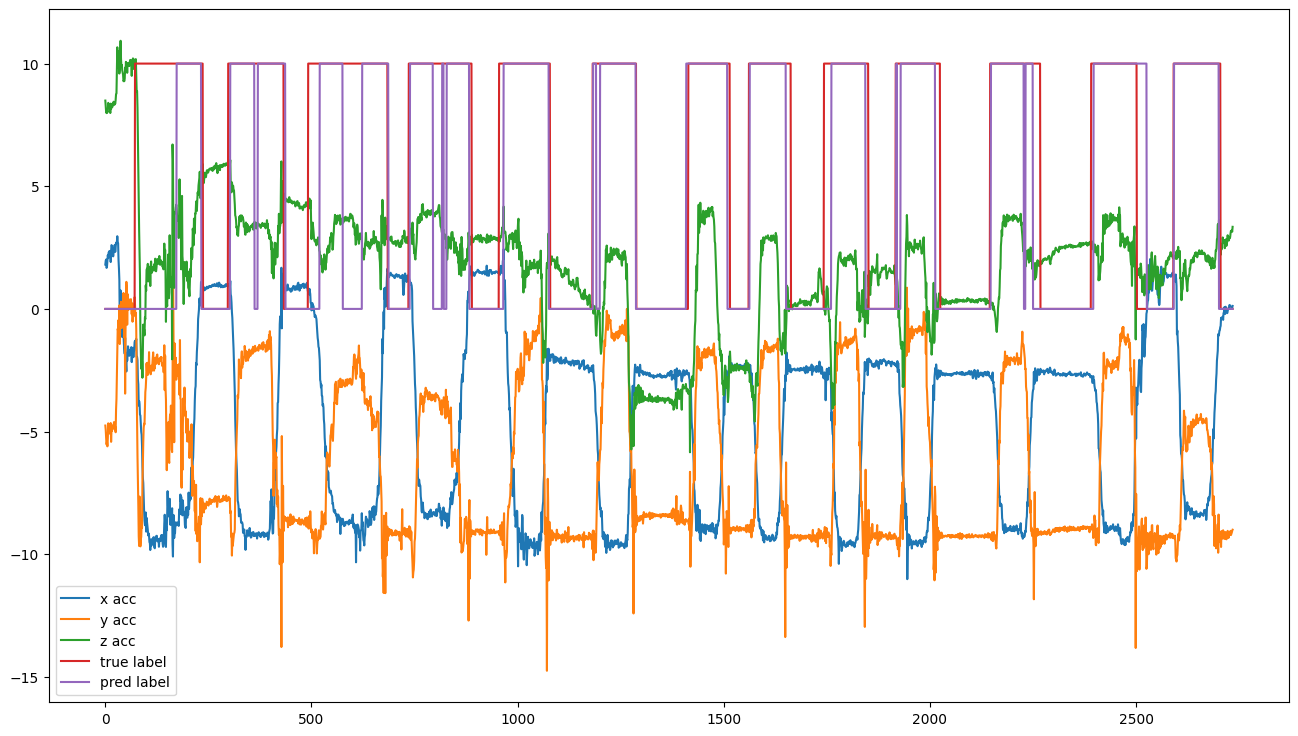

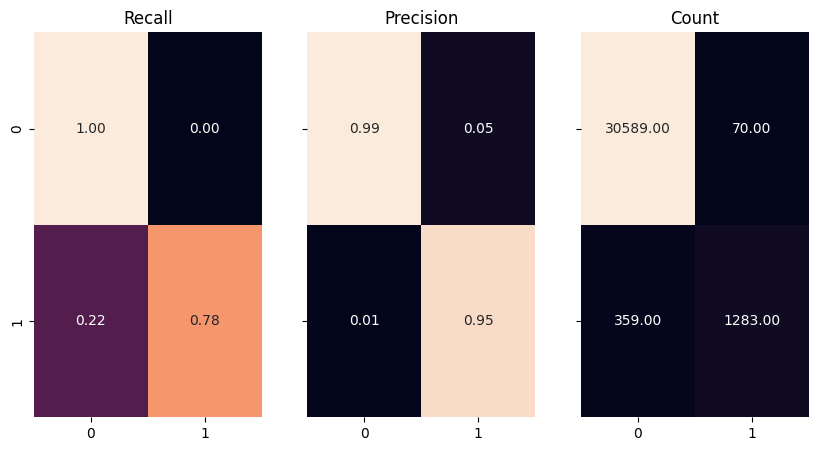

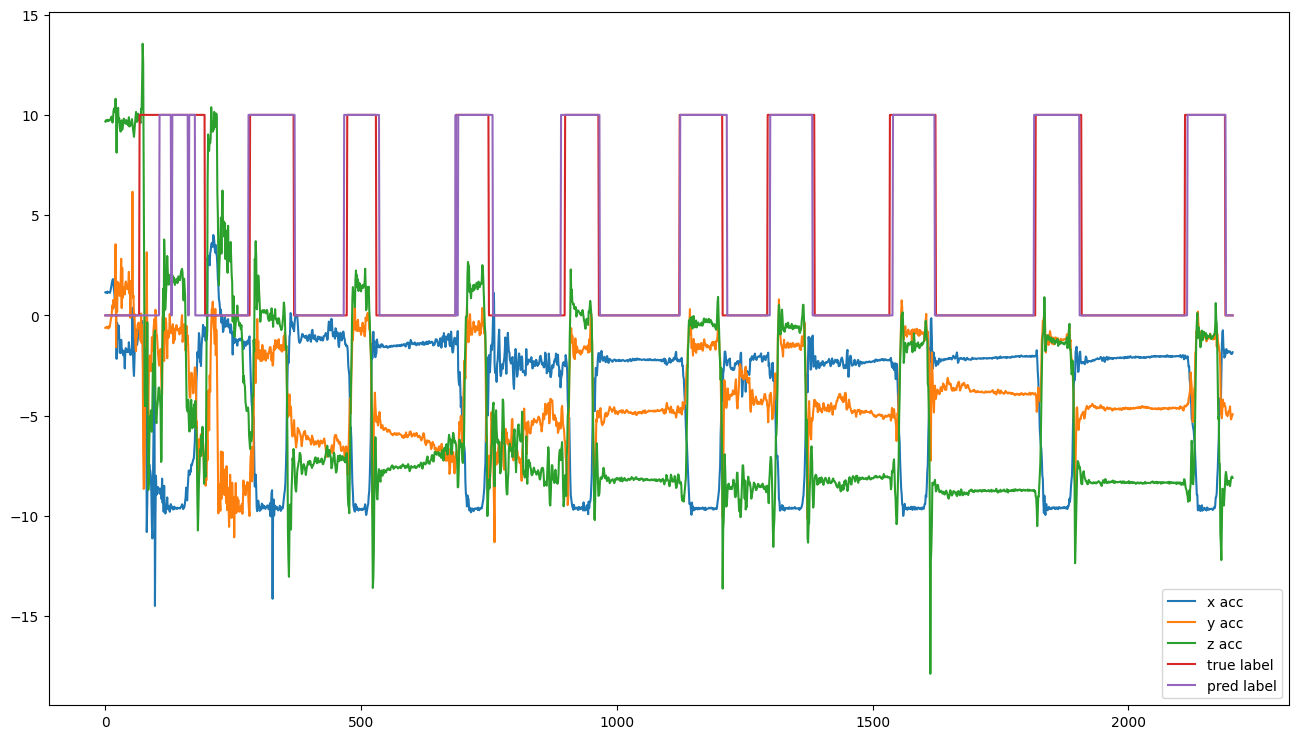

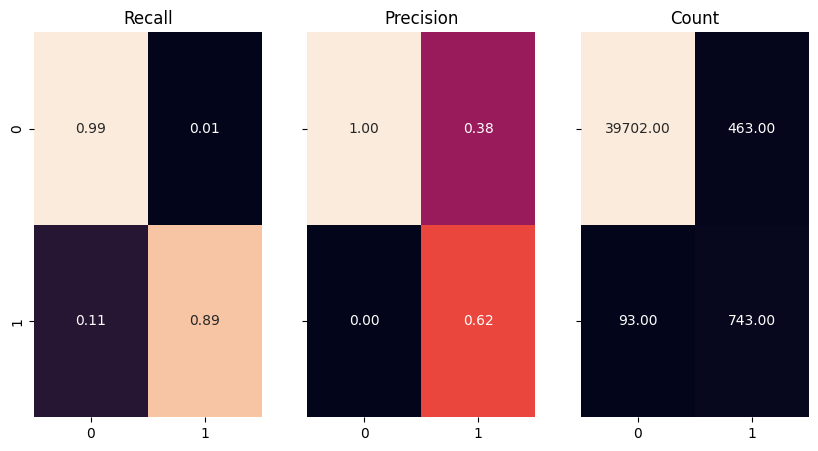

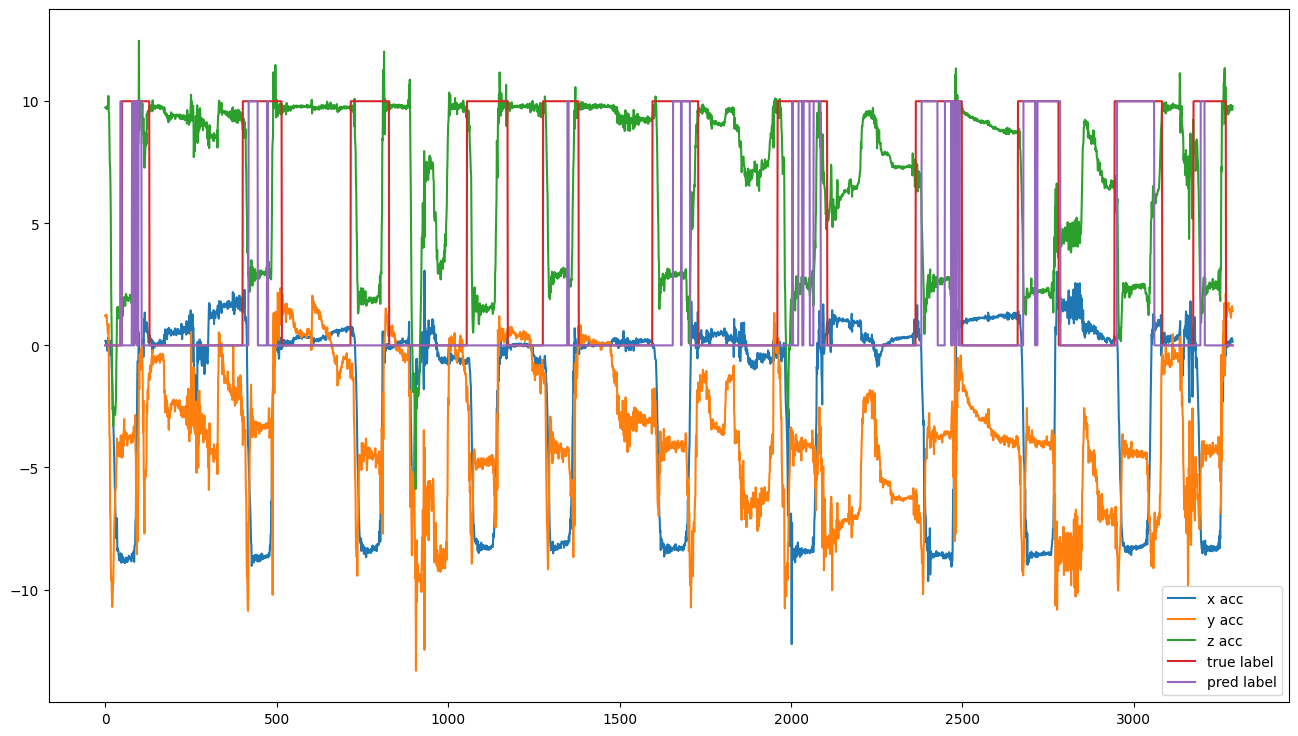

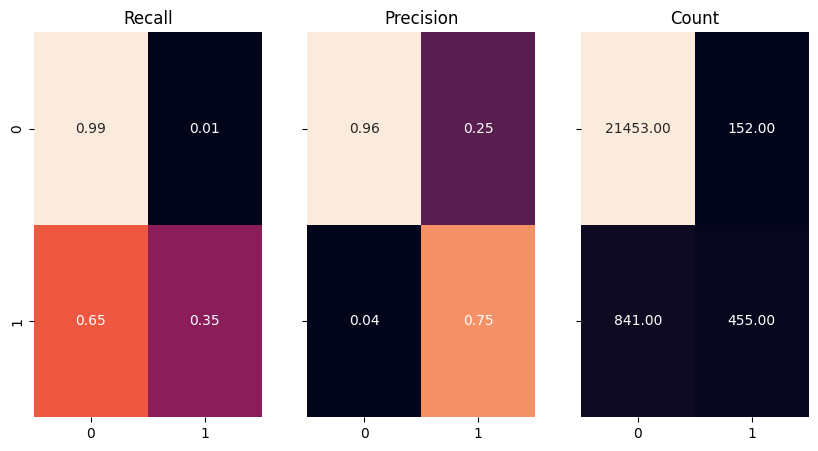

In [43]:
os.system('mkdir -p results/evaluation/holdouts')
step = 10000

for file in os.listdir('pipeline/holdouts/'):
    index = file.split('-')[0]
    print(index)
    os.system(f'mkdir results/evaluation/holdouts/{index}')
    preds = []
    n_correct = 0
    loss = 0

    # Read in holdout session
    dataset = torch.load(f'pipeline/holdouts/{file}')
    session_length = len(dataset)
    dataloader = DataLoader(dataset, batch_size=step)
    y_true = dataset[:][1]

    df = pd.read_csv(f'pipeline/1_dm/{index}.csv')
    df['y_true'] = np.pad(y_true.flatten()*10, (49, 50), mode='constant', constant_values=0)

    for X, y in dataloader:
        X = X.to(device) 
        y = y.to(device)

        logits = model(X)
        pred = torch.round(nn.Sigmoid()(logits))

        n_correct += sum(y == pred)
        preds += pred.flatten().tolist()
        loss += criterion(logits, y).item()

    y_pred = np.array(preds).reshape(-1,1)
    accuracy = (n_correct / session_length).item()
    loss = loss/len(dataloader)
    print(f'Accuracy: {100*accuracy:.4}%')
    print(f'Loss: {loss:.4}')

    df['y_pred'] = np.pad(y_pred.flatten()*10, (49, 50), mode='constant', constant_values=0)

    # Save Values
    pd.DataFrame({'Accuracy': [accuracy], 'Loss': [loss]}).to_csv(f'results/evaluation/holdouts/{index}/holdout-{index}-metrics.csv')

    # Save Figures
    start = 0
    stop = 0
    with open(f'data/{index}/{index}_data.json', 'r') as f:
        annot = json.load(f)
        start = annot['start'] // 5
        stop = annot['end'] // 5

    df_plot = df.iloc[start:stop].reset_index(drop=True)
    df_plot.columns = ['x acc', 'y acc', 'z acc', 'true label', 'pred label']
    fig, ax = plt.subplots(1, figsize=(16,9))
    ax.plot(df_plot, label=df_plot.columns)
    ax.legend()
    plt.savefig(f'results/evaluation/holdouts/{index}/holdout-{index}.jpg', dpi=400)

    # Confusion Matrix
    fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
    sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
    sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
    sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,ax=axes[2],cbar=False,fmt='.2f')
    axes[0].set_title('Recall')
    axes[1].set_title('Precision')
    axes[2].set_title('Count')
    plt.savefig(f'results/evaluation/holdouts/{index}/holdout-{index}-cm.jpg', dpi=400, bbox_inches='tight')